# **Notebook Setup: Import Libraries**

In [ ]:
# Importing the required libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

# To mount google drive to load PSX Data
from google.colab import drive

#Fallback api to fetch stock data
import yfinance

# **Setup: Parameter Adjustment**

In [ ]:
#Variables & Parameters to adjust below

#Data Loading
stock = "MEBL.KA"
split = 0.8 #Test data is automatically calculated based on this, 0.8 here means 80% Train & 20% test.

#Holidays Setup
country = "PAK" #Uses the built-in holidays list by country code, good enough for baseline.
use_custom_holidays = True #Sets to use the custom defined holidays, make sure to change them according to your needs.

# **Step 1: Data Loading**

In [ ]:
try:
  # Attempt to load data from local directory first
  df = pd.read_csv(f'../data/{stock}.csv')
  print(f"Successfully loaded data for {stock} from local directory '../data/'.")

except Exception as e:
  print(f"Failed to load data from local directory: {e}")
  print(f"Attempting to fetch data for {stock} using yfinance...")

  try:
    # Tries to load data from yfinance api since google drive methood failed.
    stock_data = yfinance.Ticker(stock)
    df = stock_data.history(period="max")

    # yfinance uses 'Date' as index, reset to a column for consistency
    df = df.reset_index()
    df.rename(columns={'Date': 'date', 'Close': 'close', 'Volume': 'volume', 'Open': 'open', 'High': 'high', 'Low': 'low'}, inplace=True)

    # Prophet requires 'ds' and 'y' columns
    df2 = pd.DataFrame()
    df2['ds'] = df['date'].dt.date
    df2['y'] = df['close']

    df = df2.copy()
    print(df.head())

    if not df.empty:
      print(f"Successfully fetched data for {stock} using yfinance.")
    else:
      print("ERROR: No data could be loaded for analysis. Please check the ticker symbol matches yfinance")

  except Exception as e:
    print(f"Failed to fetch data for {stock} using yfinance: {e}")
    print("Both methods failed. Please ensure the data file is in '/content/drive/MyDrive/psxdata/stocks/'")
    print(f"or that '{stock}' is a valid ticker symbol on yfinance.")
    df = None # Ensure df is None if both methods fail

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Failed to load data from Google Drive: [Errno 2] No such file or directory: '/content/drive/MyDrive/psxdata/stocks/MEBL.KA.csv'
Attempting to fetch data for MEBL.KA using yfinance...
           ds         y
0  2008-01-01  4.366914
1  2008-01-02  4.349676
2  2008-01-03  4.562276
3  2008-01-04  4.516310
4  2008-01-07  4.481833
Successfully fetched data for MEBL.KA using yfinance.


In [ ]:
# Displays the first 5 rows of the loaded dataset, check to make sure it's correct
if df is not None:
  print(df.tail())
else:
  print("Data could not be loaded using either method.")

           ds         y
0  2008-01-01  4.366914
1  2008-01-02  4.349676
2  2008-01-03  4.562276
3  2008-01-04  4.516310
4  2008-01-07  4.481833


# **Step 2: Data Pre-Processing**

In [ ]:
# Extract the date and closing price columns
ds = df['ds']
y = df['y']

# Calculate the number of data points for training and testing
number_of_data_points = len(df)
train_data_size = math.ceil(number_of_data_points * split)

# Split the data into training and testing sets
df_train = pd.DataFrame(data={'ds': ds[:train_data_size], 'y': y[:train_data_size]})
df_test = pd.DataFrame(data={'ds': ds[train_data_size:], 'y': y[train_data_size:]})

# **Step 3: Adding holidays to feed to the model, gives better predictions**

In [ ]:
#Custom Holidays
New_Years_Eve = pd.DataFrame({
    'holiday': 'New Years Eve',
    'ds': pd.to_datetime(['2013-12-31', '2014-12-31','2015-12-31','2016-12-31','2017-12-31','2018-12-31','2019-12-31','2020-12-31','2021-12-31', '2022-12-31',]),
    'lower_window': 0,
    'upper_window': 1,
})

Bank_Holiday = pd.DataFrame({
    'holiday': 'Bank Holiday',
    'ds': pd.to_datetime(['2013-07-01', '2014-07-01','2015-07-01','2016-07-01','2017-07-01','2018-07-01','2019-07-01','2020-07-01','2021-07-01', '2022-07-01',]),
    'lower_window': 0,
    'upper_window': 0,
})

Defence_Day = pd.DataFrame({
    'holiday': 'Defence Day',
    'ds': pd.to_datetime(['2013-09-01', '2014-09-01','2015-09-01','2016-09-01','2017-09-01','2018-09-01','2019-09-01','2020-09-01','2021-09-01', '2022-09-01',]),
    'lower_window': 0,
    'upper_window': 0,
})

# Combines all the holiday DataFrames into a single DataFrame if
# user_custom_holidays is True
if use_custom_holidays == True:
  holidays = pd.concat((New_Years_Eve, Bank_Holiday, Defence_Day))
else:
  holidays = None

# **Step 4: Initialize model and fit training data**

In [ ]:
# Instantiate prophet
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name=country)

# fit the training data
m.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqubtyp2p/9j_0oh34.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqubtyp2p/wevf_8fs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70005', 'data', 'file=/tmp/tmpqubtyp2p/9j_0oh34.json', 'init=/tmp/tmpqubtyp2p/wevf_8fs.json', 'output', 'file=/tmp/tmpqubtyp2p/prophet_model36gapv4q/prophet_model-20250630212044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:20:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:20:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#Use this to check which holidays were included in the forecast
m.train_holiday_names

,0
0,New Years Eve
1,Bank Holiday
2,Defence Day
3,Kashmir Solidarity Day
4,Pakistan Day
5,Labor Day
6,Independence Day
7,Quaid-e-Azam Day
8,Eid al-Fitr
9,Eid al-Adha


# **Step 5: Make forecast**

In [ ]:
#Makes the forecast on the test data
forecast = m.predict(df_test)

# Outputs the last 5 values of the forecasted data, filtered for the specific columns.
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
904,2025-06-23,126.260081,110.433536,142.649065
905,2025-06-24,126.297895,111.485560,142.828571
906,2025-06-25,126.346329,111.732832,142.373135
907,2025-06-26,126.392283,111.196971,142.487951
908,2025-06-27,126.482991,111.225333,142.912146


# **Step 6: Visualizing Graphs**

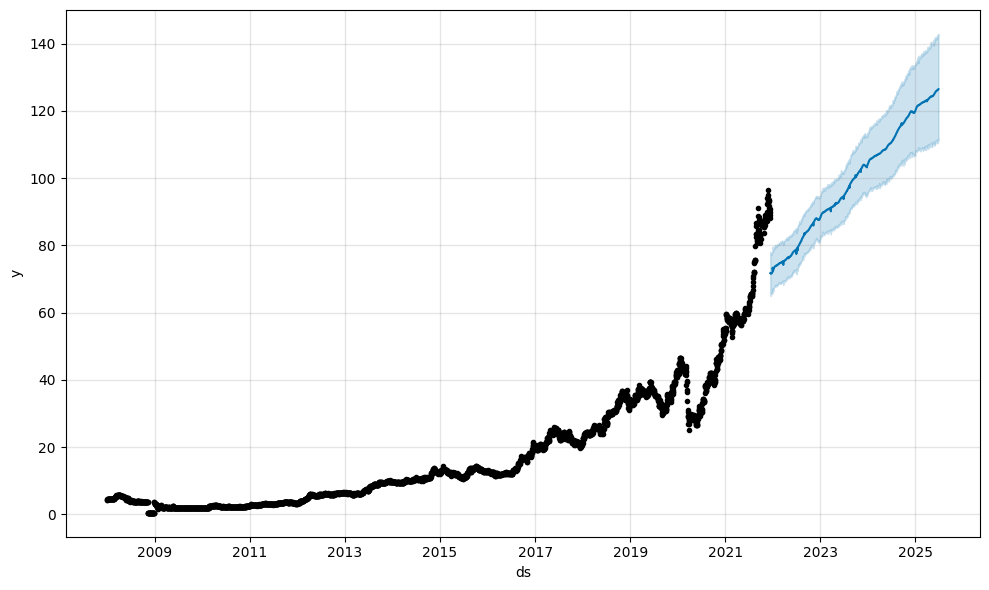

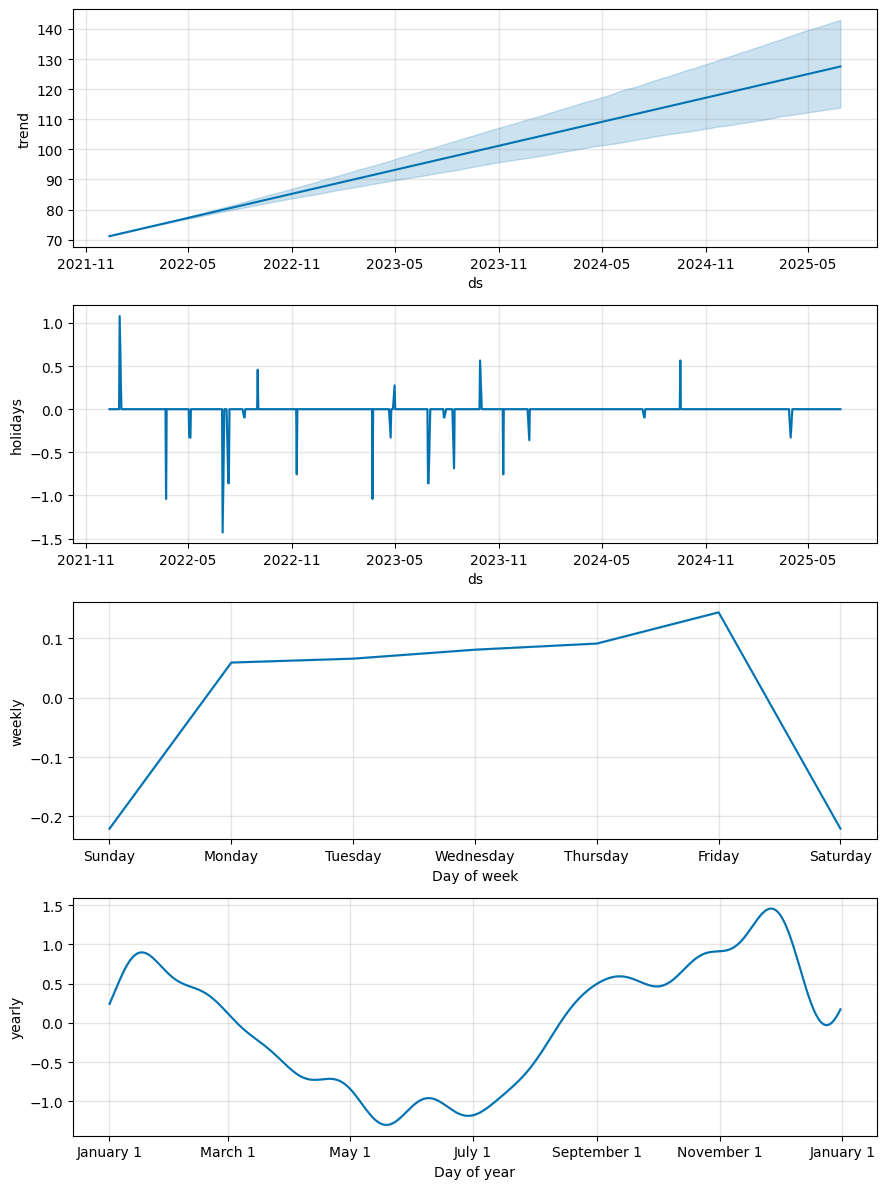

In [ ]:
#fig1 gives the standard plot chart, black like is the test data, the blue line with the spread is the forecasted data.
fig1 = m.plot(forecast)

#fig2 gives additional visual representations of things like trend or when holidays appeared.
fig2 = m.plot_components(forecast)

# **Step 7: Evaluate model accuray**

In [ ]:
# Evaluation metrics to measure model accuracy, uses MSE, MAE, and RMSE.
print("Mean Squared Error (MSE):", mean_squared_error(y_true = df_test["y"], y_pred = forecast['yhat']))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_true = df_test["y"], y_pred = forecast['yhat']))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_true = df_test["y"], y_pred = forecast['yhat'])))

Mean Squared Error (MSE): 4759.736443632395
Mean Absolute Error (MAE): 48.29025417823633
Root Mean Squared Error (RMSE): 68.99084318684905
